# Function Approximation and Control
Sarsa algorithm using tile coding

![SARSA](images/SARSA.png "Mountain Car")

In [1]:
# Import Necessary Libraries
import numpy as np
import itertools
import matplotlib.pyplot as plt
import source.tiles3 as tc
from source.rl_glue import RLGlue
from source.agent import BaseAgent
from source.utils import argmax
import source.mountaincar_env
import time

![Mountain Car](images/mountaincar.png "Mountain Car")
The car is under-powered so the agent needs to learn to rock back and forth to get enough momentum to reach the goal. At each time step the agent receives from the environment its current velocity (a float between -0.07 and 0.07), and it's current position (a float between -1.2 and 0.5). Because our state is continuous there are a potentially infinite number of states that our agent could be in. We need a function approximation method to help the agent deal with this. In this notebook we will use tile coding. We provide a tile coding implementation for you to use, imported above with tiles3.

Tile coding is introduced in [Section 9.5.4 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=239) of the textbook as a way to create features that can both provide good generalization and discrimination. It consists of multiple overlapping tilings, where each tiling is a partitioning of the space into tiles.
![Tile Coding](images/tilecoding.png "Tile Coding")

[Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html)

In [2]:
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        # Use the ranges above and self.num_tiles to scale position and velocity to the range [0, 1]
        # then multiply that range with self.num_tiles so it scales from [0, num_tiles]
        
        position_scaled = 0
        velocity_scaled = 0
        
        # ----------------
        # your code here
        
        position_scale = self.num_tiles / (0.5 - -1.2)
        velocity_scale = self.num_tiles / (0.07 - -0.07)
        
        position_scaled = position_scale * (position + 1.2)
        velocity_scaled = velocity_scale * (velocity + 0.07)
        
        # ----------------
        
        # get the tiles using tc.tiles, with self.iht, self.num_tilings and [scaled position, scaled velocity]
        # nothing to implment here
        tiles = tc.tiles(self.iht, self.num_tilings, [position_scaled, velocity_scaled])
        
        return np.array(tiles)

## SARSA Agent

There are multiple ways that we can deal with actions for the tile coder. Here we are going to use one simple method - make the size of the weight vector equal to (iht_size, num_actions). This will give us one weight vector for each action and one weight for each tile.

The tile coder returns a list of active indexes (e.g. [1, 12, 22]). So in order to get the value of a state we can index our weight vector using the action and the array of tiles that the tile coder returns:

```self.w[action][active_tiles]```

This will give us an array of values, one for each active tile, and we sum the result to get the value of that state-action pair.

In the case of a binary feature vector (such as the tile coder), the derivative is 1 at each of the active tiles, and zero otherwise.

In [3]:
class SarsaAgent(BaseAgent):
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)
        
        # We initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action.
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        # We initialize self.mctc to the mountaincar verions of the 
        # tile coder that we created
        self.tc = MountainCarTileCoder(iht_size=self.iht_size, 
                                         num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None
        
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        
        # Use np.random.random to decide if an exploritory action should be taken
        # and set chosen_action to a random action if it is
        # Otherwise choose the greedy action using the given argmax 
        # function and the action values (don't use numpy's armax)
        
        # ----------------
        # your code here
        
        for action in range(self.num_actions):
            action_values.append(self.w[action][tiles].sum())
            
        if np.random.random() < self.epsilon:
            chosen_action = np.random.randint(self.num_actions)
        else:
            chosen_action = argmax(action_values)
        
        # ----------------

        return chosen_action, action_values[chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        # ----------------
        # your code here
        
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, _ = self.select_action(active_tiles)
        
        # ----------------
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # choose the action here
        position, velocity = state
        
        # Use self.tc to set active_tiles using position and velocity
        # set current_action and action_value to the epsilon greedy chosen action using
        # the select_action function above with the active tiles
        
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, action_value, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        
        # ----------------
        # your code here
                
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, current_value = self.select_action(active_tiles)
        q_exp = current_value
        
        q_prev = self.w[self.last_action][self.previous_tiles].sum()
        
        grad = np.zeros((self.num_actions, self.iht_size))
        grad[self.last_action][self.previous_tiles] = 1
        
        target = reward + self.gamma * q_exp
        error = target - q_prev
        self.w = self.w + self.alpha * error * grad
        
        # ----------------
        
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        # Hint - there is no action_value used here because this is the end
        # of the episode.
        
        # ----------------
        # your code here
        
        q_prev = self.w[self.last_action][self.previous_tiles].sum()
        
        grad = np.zeros((self.num_actions, self.iht_size))
        grad[self.last_action][self.previous_tiles] = 1
        
        target = reward
        error = target - q_prev
        self.w = self.w + self.alpha * error * grad
        
        # ----------------
        
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        pass

RUN: 0
RUN: 5
RUN: 10
RUN: 15
stepsize: 0.25
Run Time: 64.30971026420593
RUN: 0
RUN: 5
RUN: 10
RUN: 15
stepsize: 0.015625
Run Time: 32.53829789161682
RUN: 0
RUN: 5
RUN: 10
RUN: 15
stepsize: 0.0625
Run Time: 36.09859371185303


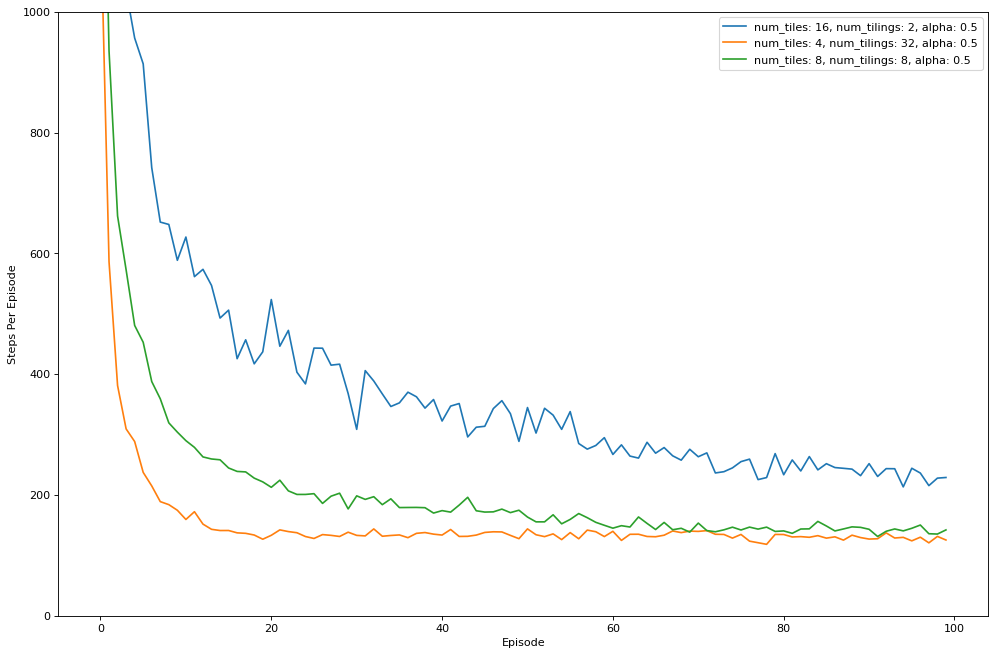

In [4]:
np.random.seed(0)

# Compare the three
num_runs = 20
num_episodes = 100
env_info = {}

agent_runs = []
# alphas = [0.2, 0.4, 0.5, 1.0]
alphas = [0.5]
agent_info_options = [{"num_tiles": 16, "num_tilings": 2, "alpha": 0.5},
                      {"num_tiles": 4, "num_tilings": 32, "alpha": 0.5},
                      {"num_tiles": 8, "num_tilings": 8, "alpha": 0.5}]
agent_info_options = [{"num_tiles" : agent["num_tiles"], 
                       "num_tilings": agent["num_tilings"],
                       "alpha" : alpha} for agent in agent_info_options for alpha in alphas]

agent = SarsaAgent
env = source.mountaincar_env.Environment
for agent_info in agent_info_options:
    all_steps = []
    start = time.time()
    for run in range(num_runs):
        if run % 5 == 0:
            print("RUN: {}".format(run))
        env = source.mountaincar_env.Environment
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        steps_per_episode = []

        for episode in range(num_episodes):
            rl_glue.rl_episode(15000)
            steps_per_episode.append(rl_glue.num_steps)
        all_steps.append(np.array(steps_per_episode))
    
    agent_runs.append(np.mean(np.array(all_steps), axis=0))
    print("stepsize:", rl_glue.agent.alpha)
    print("Run Time: {}".format(time.time() - start))

plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.array(agent_runs).T)
plt.xlabel("Episode")
plt.ylabel("Steps Per Episode")
plt.yscale("linear")
plt.ylim(0, 1000)
plt.legend(["num_tiles: {}, num_tilings: {}, alpha: {}".format(agent_info["num_tiles"], 
                                                               agent_info["num_tilings"],
                                                               agent_info["alpha"])
            for agent_info in agent_info_options])

Here we can see that using 32 tilings and 4 x 4 tiles does a little better than 8 tilings with 8x8 tiles. Both seem to do much better than using 2 tilings, with 16 x 16 tiles.